In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


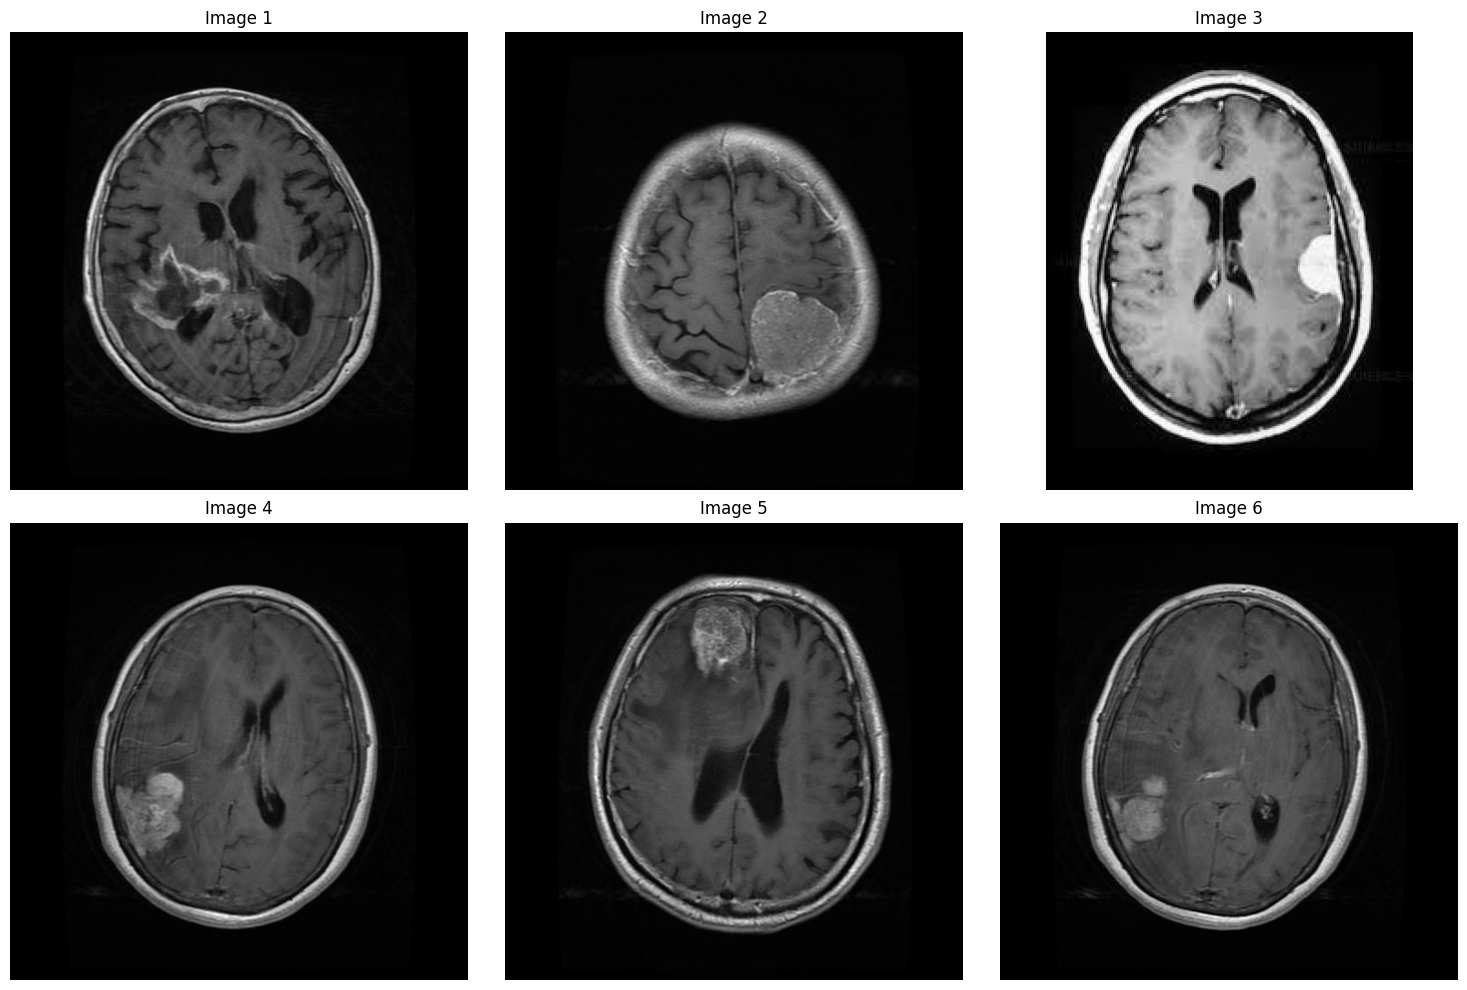

In [ ]:
# Import libraries
import cv2
import os
from google.colab import drive
from matplotlib import pyplot as plt



# Define dataset directory
dataset_dir = "/content/drive/MyDrive/Image Dataset/Dataset/Dataset"  # Replace with your folder path

# List all image files in the directory
image_files = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir) if file.endswith(('.png', '.jpg', '.jpeg'))]

# Display 5-6 images
num_images_to_display = 6  # Number of images to display
plt.figure(figsize=(15, 10))  # Adjust figure size

for i, image_path in enumerate(image_files[:num_images_to_display]):  # Loop through the first few images
    image = cv2.imread(image_path)  # Load the image
    plt.subplot(2, 3, i + 1)  # Create a subplot grid (2 rows, 3 columns)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f"Image {i + 1}")  # Title for each image
    plt.axis("off")  # Remove axis

plt.tight_layout()  # Adjust spacing
plt.show()


**Convert Image to Grayscale**

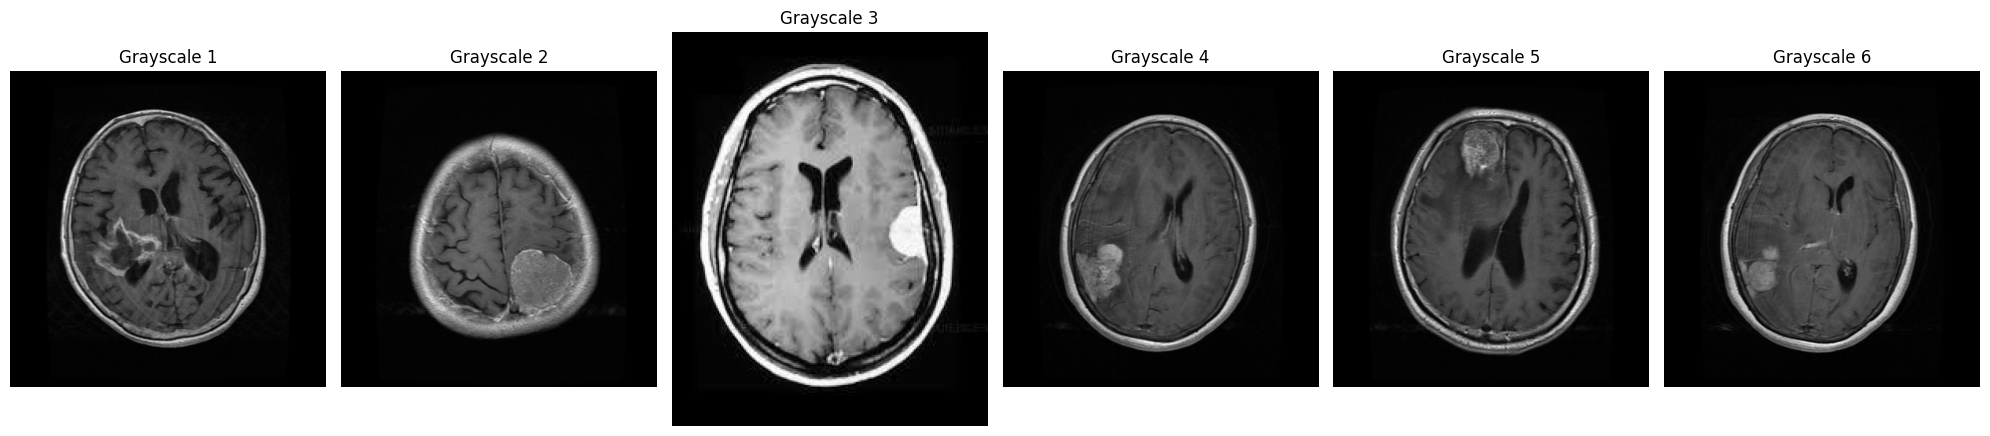

In [ ]:
# Convert all images to Grayscale
grayscale_images = []

for image_path in image_files:
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale_images.append(gray_image)

# Visualize the first 5–6 grayscale images side by side
fig, axs = plt.subplots(1, 6, figsize=(20, 5))  # 1 row, 6 columns
for i, gray_image in enumerate(grayscale_images[:6]):  # Adjust number as needed
    axs[i].imshow(gray_image, cmap='gray')
    axs[i].set_title(f"Grayscale {i+1}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()



** Apply Denoising**

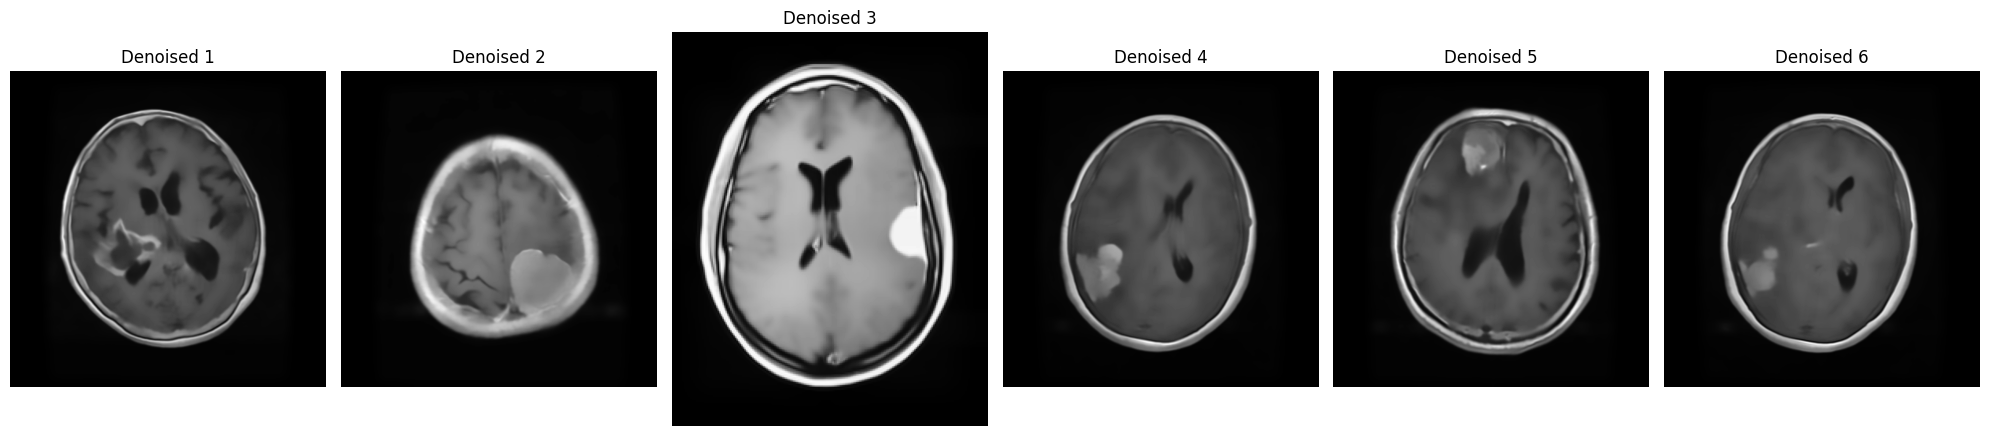

In [ ]:
# Apply denoising to all grayscale images
denoised_images = []

for gray_image in grayscale_images:
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 30, 7, 21)
    denoised_images.append(denoised_image)

# Visualize the first 5–6 denoised images side by side
fig, axs = plt.subplots(1, 6, figsize=(20, 5))  # 1 row, 6 columns
for i, denoised_image in enumerate(denoised_images[:6]):  # Adjust number as needed
    axs[i].imshow(denoised_image, cmap='gray')
    axs[i].set_title(f"Denoised {i+1}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()


**Apply Histogram Equalization**

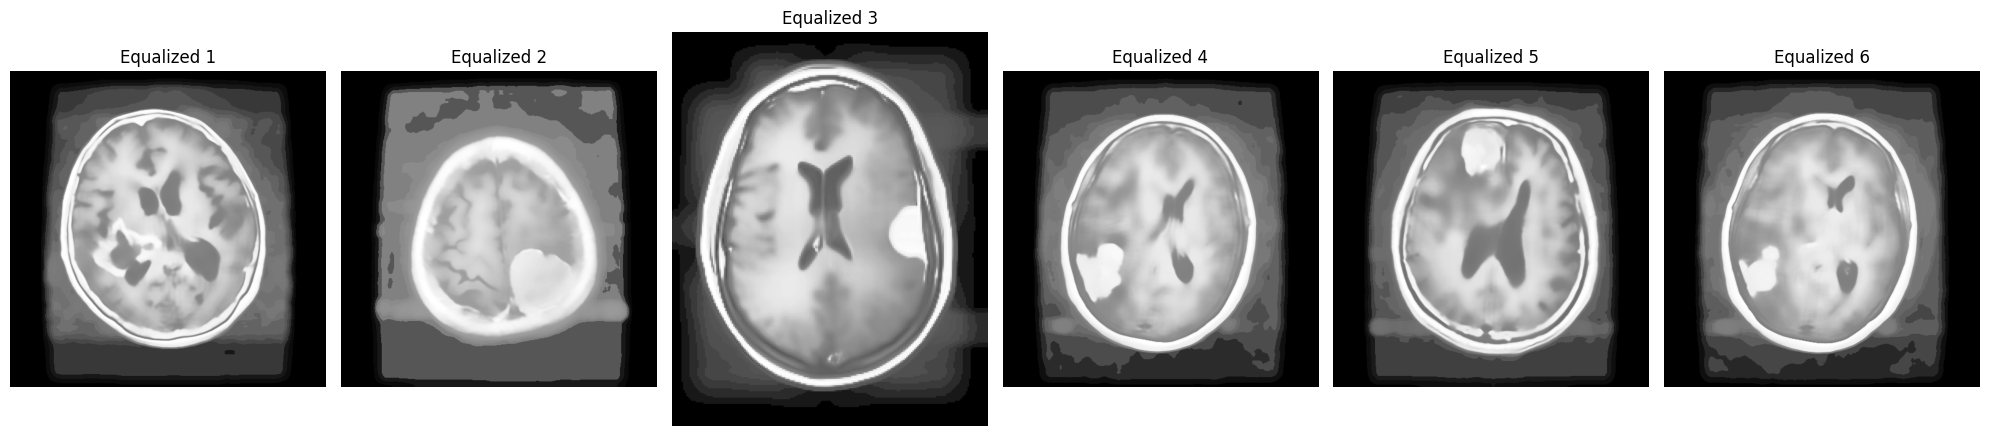

In [ ]:
# Apply histogram equalization to all denoised images
equalized_images = []

for denoised_image in denoised_images:
    equalized_image = cv2.equalizeHist(denoised_image)
    equalized_images.append(equalized_image)

# Visualize the first 5–6 histogram equalized images side by side
fig, axs = plt.subplots(1, 6, figsize=(20, 5))  # 1 row, 6 columns
for i, equalized_image in enumerate(equalized_images[:6]):  # Adjust number as needed
    axs[i].imshow(equalized_image, cmap='gray')
    axs[i].set_title(f"Equalized {i+1}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()


**Croping** Regions of Interest (ROI)

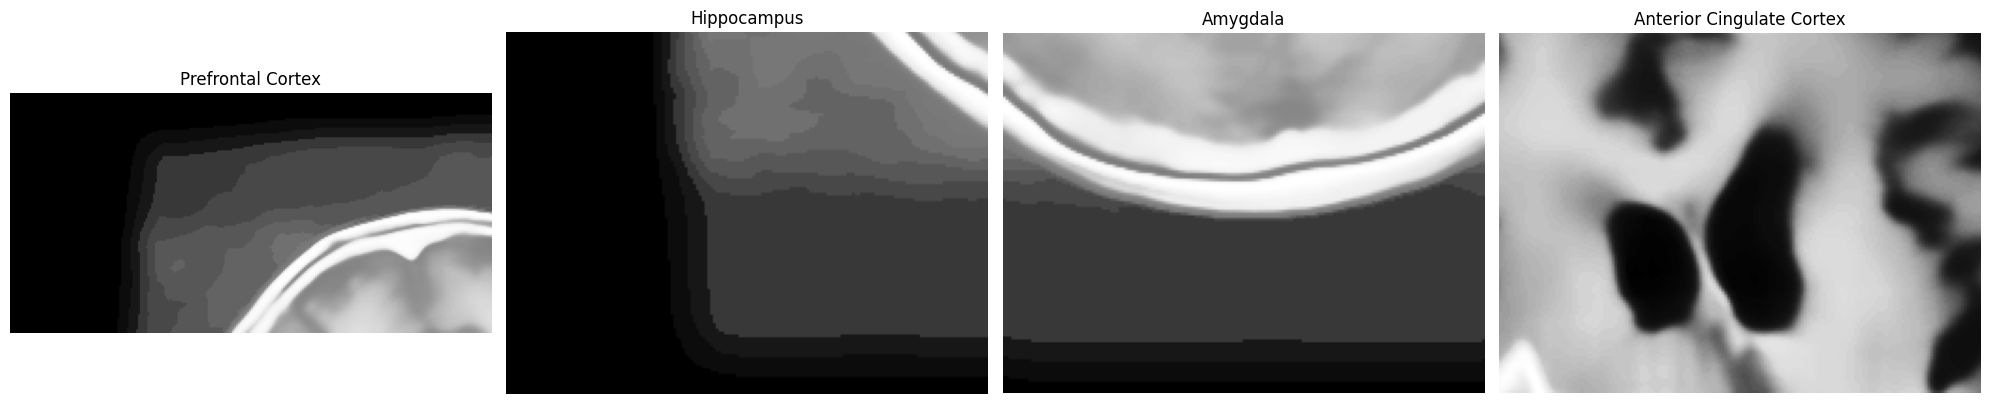

In [ ]:
# Define function to crop specific regions
def crop_roi(image):
    height, width = image.shape
    regions = {
        "Prefrontal Cortex": image[0:height//4, :width//2],  # Adjust coordinates
        "Hippocampus": image[3*height//4:, :width//3],  # Adjust coordinates
        "Amygdala": image[3*height//4:, width//3:2*width//3],  # Adjust coordinates
        "Anterior Cingulate Cortex": image[height//4:height//2, width//3:2*width//3],  # Adjust coordinates
    }
    return regions

# Apply ROI cropping to all equalized images
cropped_regions_list = []

for equalized_image in equalized_images:
    cropped_regions = crop_roi(equalized_image)
    cropped_regions_list.append(cropped_regions)

# Visualize ROIs for the first image as an example (regions side by side)
sample_cropped_regions = cropped_regions_list[0]  # Adjust index as needed

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns for 4 regions
for i, (region_name, roi) in enumerate(sample_cropped_regions.items()):
    axs[i].imshow(roi, cmap='gray')
    axs[i].set_title(f"{region_name}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Define output directory
output_dir = "/content/drive/MyDrive/Image Dataset/Processed_Images"
os.makedirs(output_dir, exist_ok=True)

# Save processed images
for i, (gray_image, denoised_image, equalized_image) in enumerate(zip(grayscale_images, denoised_images, equalized_images)):
    cv2.imwrite(os.path.join(output_dir, f"grayscale_image_{i+1}.png"), gray_image)
    cv2.imwrite(os.path.join(output_dir, f"denoised_image_{i+1}.png"), denoised_image)
    cv2.imwrite(os.path.join(output_dir, f"equalized_image_{i+1}.png"), equalized_image)

# Save ROIs
for i, cropped_regions in enumerate(cropped_regions_list):
    for region_name, roi in cropped_regions.items():
        region_output_path = os.path.join(output_dir, f"image_{i+1}_{region_name.replace(' ', '_')}.png")
        cv2.imwrite(region_output_path, roi)

print(f"Processed images saved in: {output_dir}")


Processed images saved in: /content/drive/MyDrive/Image Dataset/Processed_Images


In [59]:
import numpy as np
import cv2

# Define region to depression label mapping
region_to_depression_mapping = {
    "Prefrontal Cortex": "Mild Depression",
    "Hippocampus": "Severe Depression",
    "Amygdala": "Severe Depression",
    "Anterior Cingulate Cortex": "Non-depressed"
}

# Define a target size for resizing images (e.g., 100x100 pixels)
target_size = (100, 100)

# Prepare feature vectors and labels
X = []  # Features
y = []  # Labels

for i, cropped_regions in enumerate(cropped_regions_list):
    for region_name, roi in cropped_regions.items():
        # Resize the ROI to a fixed size
        resized_roi = cv2.resize(roi, target_size)

        # Flatten the resized ROI to 1D
        flattened_roi = resized_roi.flatten()

        # Append the feature vector and the corresponding label
        X.append(flattened_roi)
        y.append(region_to_depression_mapping[region_name])  # Use depression labels

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")

print(f"Original X shape: {X.shape}")
print(f"Shape of a single flattened ROI: {X[0].shape}")


Feature shape: (240, 10000), Labels shape: (240,)
Original X shape: (240, 10000)
Shape of a single flattened ROI: (10000,)


In [60]:
# Reshaping X to (num_samples, height, width, channels)
X = X.reshape(X.shape[0], 100, 100, 1)  # 240 samples, 100x100 image, 1 channel (grayscale)

# Verify the new shape of X
print(f"Reshaped X shape: {X.shape}")


Reshaped X shape: (240, 100, 100, 1)


In [64]:
# Print the unique labels in y
print(set(y))  # If y is a list, this will print the unique values


{'Severe Depression', 'Non-depressed', 'Mild Depression'}


In [65]:
# Updated label mapping to include 'Non-depressed' (and any other labels)
label_mapping = {
    'Non-depressed': 0,
    'Mild Depression': 1,
    'Moderate Depression': 2,
    'Severe Depression': 3
}

# Replace the labels with integer values
y_int = [label_mapping[label] for label in y]

# Verify the converted labels
print(f"Converted labels: {y_int[:10]}")


Converted labels: [1, 3, 3, 0, 1, 3, 3, 0, 1, 3]


In [66]:
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoding
y = to_categorical(y_int)

# Verify the shape of the one-hot encoded labels
print(f"One-hot encoded y shape: {y.shape}")


One-hot encoded y shape: (240, 4)


In [67]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (192, 100, 100, 1), X_test shape: (48, 100, 100, 1)
y_train shape: (192, 4), y_test shape: (48, 4)


In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))  # First convolution layer
model.add(MaxPooling2D((2, 2)))  # Pooling layer

model.add(Conv2D(64, (3, 3), activation='relu'))  # Second convolution layer
model.add(MaxPooling2D((2, 2)))  # Pooling layer

# Flatten the feature map to connect to fully connected layers
model.add(Flatten())

# Add fully connected layer
model.add(Dense(128, activation='relu'))

# Output layer (4 classes: adjust the number of classes as needed)
model.add(Dense(4, activation='softmax'))  # Output layer with softmax for 4-class classification

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 705ms/step - accuracy: 0.2628 - loss: 188.1250 - val_accuracy: 0.6458 - val_loss: 89.2838
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 633ms/step - accuracy: 0.5692 - loss: 77.7796 - val_accuracy: 0.3542 - val_loss: 30.5209
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.5470 - loss: 17.5306 - val_accuracy: 0.8958 - val_loss: 3.1019
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step - accuracy: 0.7971 - loss: 6.8658 - val_accuracy: 0.6875 - val_loss: 19.0215
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - accuracy: 0.7298 - loss: 14.1700 - val_accuracy: 0.9375 - val_loss: 2.1116
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 470ms/step - accuracy: 0.9467 - loss: 1.3667 - val_accuracy: 0.9375 - val_loss: 1.8891
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - accuracy: 0.9783 - loss: 0.7249 - val_accuracy: 0.7500 - val_loss: 13.5158
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 544ms/step - accuracy: 0.8963 - loss: 4.9642 - val_accuracy: 0.9167 - 

In [70]:
# Step 6: Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9757 - loss: 0.4361
Test Loss: 0.373969167470932
Test Accuracy: 0.9791666865348816


In [71]:
# Step 7: Make predictions on new data
predictions = model.predict(X_test)

# Example: Output predicted class labels for the first few test samples
predicted_labels = np.argmax(predictions, axis=1)
print(f"Predicted Labels for first 5 test samples: {predicted_labels[:5]}")

# If you need to map the predicted label indices back to the original class names:
class_names = ['Non-depressed', 'Mild Depression', 'Moderate Depression', 'Severe Depression']
predicted_class_names = [class_names[label] for label in predicted_labels]
print(f"Predicted Class Names for first 5 test samples: {predicted_class_names[:5]}")


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
Predicted Labels for first 5 test samples: [1 3 3 3 1]
Predicted Class Names for first 5 test samples: ['Mild Depression', 'Severe Depression', 'Severe Depression', 'Severe Depression', 'Mild Depression']


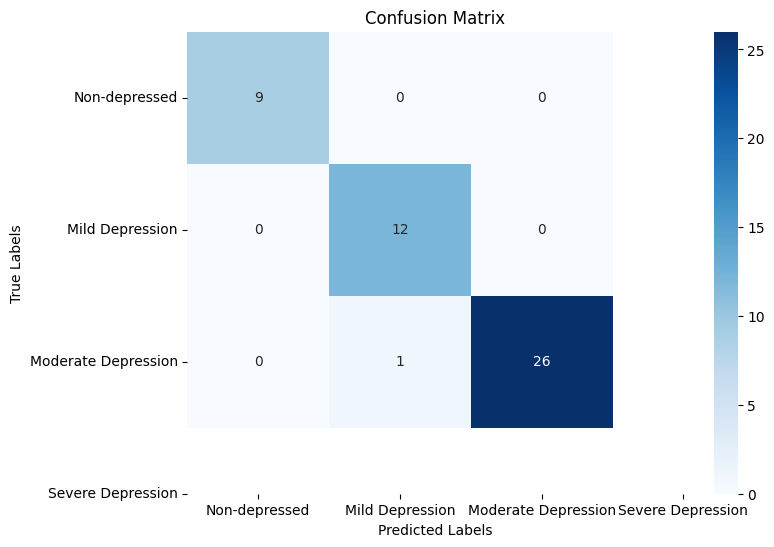

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 8: Compute confusion matrix
y_true = np.argmax(y_test, axis=1)  # Get the true labels
conf_matrix = confusion_matrix(y_true, predicted_labels)

# Step 9: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
